In [1]:
import numpy as np
# Importing Pandas Library 
import pandas as pd
import matplotlib.pyplot as plt
from preprocessing import *
import os
import joblib
from sklearn.preprocessing import MinMaxScaler
from utils import *

import tensorflow as tf
import keras
from tensorflow.keras.models import Model, load_model

from models.EEGNet import *

from sklearn.metrics import confusion_matrix

from preprocessing import *

import warnings
warnings.filterwarnings("ignore")

2024-10-20 10:11:21.057176: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-20 10:11:21.065142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-20 10:11:21.073262: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-20 10:11:21.075645: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-20 10:11:21.082218: I tensorflow/core/platform/cpu_feature_guar

In [2]:
@keras.saving.register_keras_serializable(package="my_package", name="UpdatedIoU")
class UpdatedIoU(tf.keras.metrics.IoU):
  def __init__(self,
        num_classes,
        target_class_ids,
        name=None,
        dtype=None,
        ignore_class=None,
        sparse_y_true=True,
        sparse_y_pred=True,
        axis=-1
    ):
    super(UpdatedIoU, self).__init__(
        num_classes=num_classes,
        target_class_ids=target_class_ids,
        name=name,
        dtype=dtype,
        ignore_class=ignore_class,
        sparse_y_true=sparse_y_true,
        sparse_y_pred=sparse_y_pred,
        axis=axis
    )

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)


In [3]:
model = load_model(r'./checkpoints/orthogonal_trainable_true.keras')
model.summary()

I0000 00:00:1729393881.963937  902208 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729393881.990346  902208 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729393881.994370  902208 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729393881.999566  902208 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ eyebrows input      │ (None, 4, 128, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ left input          │ (None, 4, 128, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right input         │ (None, 4, 128, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ both input          │ (None, 4, 128, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teeth input         │ (None, 4, 128, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ eyebrows            │ (None, 64)        │      2,848 │ eyebrows          │
│ (Functional)        │                   │            │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ left (Functional)   │ (None, 64)        │      2,848 │ left input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right (Functional)  │ (None, 64)        │      2,848 │ right input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ both (Functional)   │ (None, 64)        │      2,848 │ both input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teeth (Functional)  │ (None, 64)        │      2,848 │ teeth input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 320)       │          0 │ eyebrows[0][0],   │
│ (Concatenate)       │                   │            │ left[0][0],       │
│                     │                   │            │ right[0][0],      │
│                     │                   │            │ both[0][0],       │
│                     │                   │            │ teeth[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │    328,704 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 768)       │    393,984 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 128, 6)    │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax             │ (None, 128, 6)    │          0 │ reshape[0][0]     │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,783,586 (14.43 MB)

 Trainable params: 1,260,928 (4.81 MB)

 Non-trainable params: 800 (3.12 KB)

 Optimizer params: 2,521,858 (9.62 MB)

In [4]:
label_name = ['eyebrows', 'left', 'right', 'both', 'teeth']

train_x = []
test_x = []
train_y = []
test_y = []
for label in label_name:
    dataset = np.load(f'./running/{label}.npz')

    print(dataset['train_x'].shape, dataset['train_y'].shape, dataset['test_x'].shape, dataset['test_y'].shape)
    train_x.append(dataset['train_x'][:51500])
    train_y.append(dataset['train_y'][:51500])
    test_x.append(dataset['test_x'][:12900])
    test_y.append(dataset['test_y'][:12900])

train_x = np.concatenate(train_x)
train_y = np.concatenate(train_y)
test_x = np.concatenate(test_x)
test_y = np.concatenate(test_y)


train_x = train_x.transpose((0, 2, 1))
test_x = test_x.transpose((0, 2, 1))

train_x = np.expand_dims(train_x, axis=-1)
test_x = np.expand_dims(test_x, axis=-1)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(65972, 128, 20) (65972, 128) (16493, 128, 20) (16493, 128)
(57701, 128, 20) (57701, 128) (14426, 128, 20) (14426, 128)
(53477, 128, 20) (53477, 128) (13370, 128, 20) (13370, 128)
(51868, 128, 20) (51868, 128) (12968, 128, 20) (12968, 128)
(51752, 128, 20) (51752, 128) (12939, 128, 20) (12939, 128)
(257500, 20, 128, 1) (257500, 128) (64500, 20, 128, 1) (64500, 128)


In [5]:
y_train_pred = model.predict([
    train_x[:, :4], 
    train_x[:, 4:8], 
    train_x[:, 8:12],
    train_x[:, 12:16],
    train_x[:, 16:20]
])

y_test_pred = model.predict([
    test_x[:, :4], 
    test_x[:, 4:8], 
    test_x[:, 8:12],
    test_x[:, 12:16],
    test_x[:, 16:20]
])
y_train_pred.shape, y_test_pred.shape

I0000 00:00:1729393925.422035  902338 service.cc:146] XLA service 0x793b4c015c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729393925.422055  902338 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-10-20 10:12:05.436045: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-20 10:12:05.493439: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 126/8047 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step   

I0000 00:00:1729393925.840284  902338 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8047/8047 ━━━━━━━━━━━━━━━━━━━━ 8s 874us/step
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 2s 908us/step


((257500, 128, 6), (64500, 128, 6))

In [6]:
y_train_pred_argmax = np.argmax(y_train_pred, 2)
y_test_pred_argmax = np.argmax(y_test_pred, 2)

y_train_pred_argmax.shape, y_test_pred_argmax.shape

((257500, 128), (64500, 128))

In [7]:
iou_results = {}
for _class in range(5):
    iou_metric = tf.keras.metrics.IoU(num_classes=6, target_class_ids=[_class+1])
    print(f"Class [{label_name[_class]}] - Train:", iou_metric(train_y, y_train_pred_argmax))
    print(f"Class [{label_name[_class]}] - Test:", iou_metric(test_y, y_test_pred_argmax))
    iou_results[label_name[_class]] = [
        tf.get_static_value(iou_metric(train_y, y_train_pred_argmax)), 
        tf.get_static_value(iou_metric(test_y, y_test_pred_argmax))
    ]
    print(f"Class [{label_name[_class]}] - Train:", iou_results[label_name[_class]][0])
    print(f"Class [{label_name[_class]}] - Test:", iou_results[label_name[_class]][1])

Class [eyebrows] - Train: tf.Tensor(0.9085359, shape=(), dtype=float32)
Class [eyebrows] - Test: tf.Tensor(0.90745497, shape=(), dtype=float32)
Class [eyebrows] - Train: 0.9079352
Class [eyebrows] - Test: 0.90745497
Class [left] - Train: tf.Tensor(0.9284675, shape=(), dtype=float32)
Class [left] - Test: tf.Tensor(0.92823607, shape=(), dtype=float32)
Class [left] - Train: 0.9283388
Class [left] - Test: 0.92823607
Class [right] - Train: tf.Tensor(0.93390566, shape=(), dtype=float32)
Class [right] - Test: tf.Tensor(0.9336903, shape=(), dtype=float32)
Class [right] - Train: 0.93378603
Class [right] - Test: 0.9336903
Class [both] - Train: tf.Tensor(0.8799156, shape=(), dtype=float32)
Class [both] - Test: tf.Tensor(0.87978315, shape=(), dtype=float32)
Class [both] - Train: 0.879842
Class [both] - Test: 0.87978315
Class [teeth] - Train: tf.Tensor(0.9196759, shape=(), dtype=float32)
Class [teeth] - Test: tf.Tensor(0.91909075, shape=(), dtype=float32)
Class [teeth] - Train: 0.9193509
Class [tee

In [8]:
iou_results

{'eyebrows': [0.9079352, 0.90745497],
 'left': [0.9283388, 0.92823607],
 'right': [0.93378603, 0.9336903],
 'both': [0.879842, 0.87978315],
 'teeth': [0.9193509, 0.91909075]}

(0.85, 0.96)

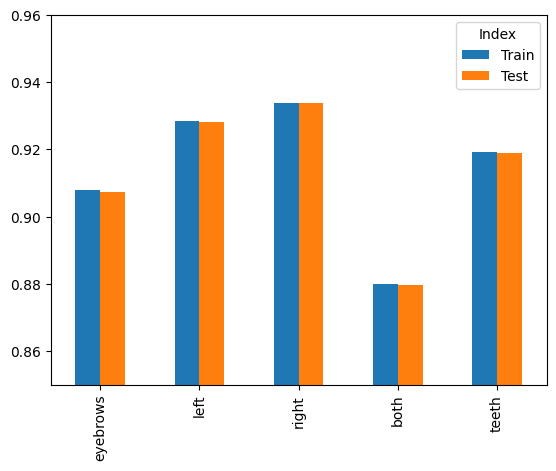

In [9]:
iou_results['Index'] = ['Train', 'Test']
pd.DataFrame.from_dict(iou_results).set_index('Index').T.plot(kind='bar')
plt.ylim(0.85, 0.96)

In [10]:
cm_total = np.zeros((6, 6))

for y_t, y_p in zip(train_y, y_train_pred_argmax):
    cm = confusion_matrix(y_t, y_p, labels=[0, 1, 2, 3, 4, 5])
    cm = np.array(cm)
    cm_total = cm_total + cm

result = []
for cls in range(6):
    tp = cm_total[cls, cls]
    fn = np.sum(np.delete(cm_total[cls, :], cls))
    fp = np.sum(np.delete(cm_total[:, cls], cls))
    tn = np.delete(cm_total, cls, axis=0)
    tn = np.sum(np.delete(tn, cls, axis=1))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = (2 * precision * recall) / (precision + recall)
    acc = (tp + tn) / (tp + fn + tn + fp)
    specifity = tn/(tn+fp)

    result.append([precision, recall, f1, acc, specifity])

result = np.array(result)

print(f'precision, recall, f1, acc, specifity\n{result}')

precision, recall, f1, acc, specifity
[[0.95879939 0.95561912 0.95720662 0.95651635 0.95744614]
 [0.95377666 0.95038214 0.95207637 0.98918407 0.99412957]
 [0.96021009 0.96561937 0.96290713 0.99256405 0.99555633]
 [0.96116658 0.97052566 0.96582345 0.99337643 0.99581516]
 [0.93883909 0.93342164 0.93612252 0.98840143 0.9939088 ]
 [0.95234058 0.96404596 0.95815752 0.99237084 0.99519303]]


In [11]:
cm_total = np.zeros((6, 6))

for y_t, y_p in zip(test_y, y_test_pred_argmax):
    cm = confusion_matrix(y_t, y_p, labels=[0, 1, 2, 3, 4, 5])
    cm = np.array(cm)
    cm_total = cm_total + cm

result = []
for cls in range(6):
    tp = cm_total[cls, cls]
    fn = np.sum(np.delete(cm_total[cls, :], cls))
    fp = np.sum(np.delete(cm_total[:, cls], cls))
    tn = np.delete(cm_total, cls, axis=0)
    tn = np.sum(np.delete(tn, cls, axis=1))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = (2 * precision * recall) / (precision + recall)
    acc = (tp + tn) / (tp + fn + tn + fp)
    specifity = tn/(tn+fp)

    result.append([precision, recall, f1, acc, specifity])

result = np.array(result)

print(f'precision, recall, f1, acc, specifity\n{result}')

precision, recall, f1, acc, specifity
[[0.9579792  0.95428521 0.95612864 0.9553595  0.9564765 ]
 [0.95057802 0.94764494 0.94910922 0.98852689 0.99372973]
 [0.95959256 0.96499706 0.96228722 0.99241642 0.99547188]
 [0.96011981 0.97042634 0.96524556 0.99330632 0.99573005]
 [0.93813221 0.93337983 0.93574998 0.98826841 0.99379842]
 [0.95033136 0.96287182 0.95656049 0.99214862 0.99503632]]


In [12]:
auc = tf.keras.metrics.AUC(
    multi_label=True,
    num_labels=6,
    from_logits=True
)
auc_result = auc(tf.cast(train_y, float), tf.cast(y_train_pred_argmax, float))
auc_result

2024-10-20 10:13:18.105001: W tensorflow/core/framework/op_kernel.cc:1828] INVALID_ARGUMENT: required broadcastable shapes
2024-10-20 10:13:18.105022: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: required broadcastable shapes


InvalidArgumentError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} required broadcastable shapes [Op:AddV2] name: 